# Using TF and OpenCV to differentiate between leukocytes

_This project aims to provide a model that will be able to identify different types of leukocytes in an image of a blood sample. It is presented as a simple case study._

Although all leukocytes participate on the protection of our bodies from pathogens in some way or another, the exact function of a leukocyte depends on its type. It is important to be able to discern between these types if we want to study immune responses. In this notebook I devise a model that could be used to analyse samples quickly and accurately.

__You can find the final model in the last section of this notebook.__

In [1]:
import random

import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import os

In [2]:
LABEL_PATH = "data/labels.csv"
IMAGE_PATH = "data/images"
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

## Dataset overview and cleaning

I got the [dataset](https://www.kaggle.com/paultimothymooney/blood-cells) from Kaggle. Main characteristics:

- it contains 367 annotated `640 x 480` images of blood samples
- most of the images contain exactly one white blood cell of a certain type
    - types: eosinophils, lymphocytes, monocytes, neutrophils, and basophils
    - each image in the dataset has an accompanying label specifying which type of leukocyte(s) it shows


_Note that there is an alternative dataset on Kaggle with augmented data and some additional annotations, but we won't use it to simulate more typical research conditions._

First, let's load the dataset and look at the number of each leukocyte type.

In [3]:
def load_image(path):
    try:
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    except:
        return None


data = pd.read_csv(LABEL_PATH)[["Image", "Category"]]
data = data.rename(columns={"Category": "label", "Image": "id"})
data = data[-pd.isna(data["label"])]

data["path"] = [f"{IMAGE_PATH}BloodImage_{id:05}.jpg" for id in data["id"]]

data["image"] = [load_image(path) for path in data["path"]]
data = data[[im is not None for im in data["image"]]]

data["label"].value_counts()

NEUTROPHIL                206
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   20
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,EOSINOPHIL       1
LYMPHOCYTE, LYMPHOCYTE      1
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: label, dtype: int64

As you can see above, the dataset is very unbalanced. It also seems that some images contain more than one leukocyte. Let's check that by looking at some of the images.

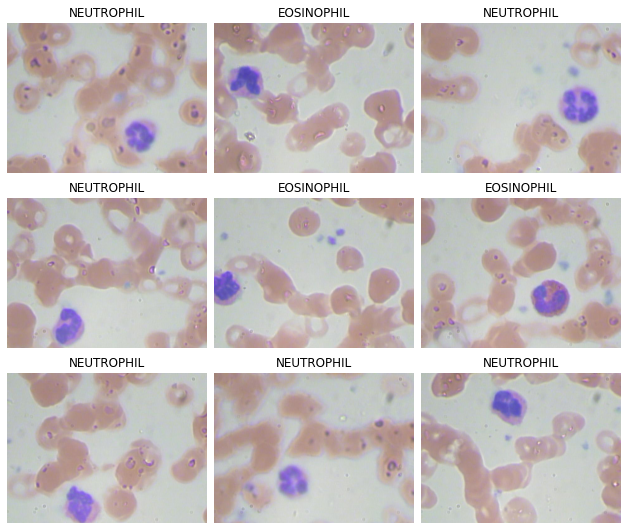

In [116]:
def plot_grid(images, titles=None, title=None, cmap=None, top=1.15, size=(3, 3)):
    if titles is None:
        titles = [None] * len(images)
        padding = 0.1
    else:
        padding = (0.1, 0.35)

    fig = plt.figure(figsize=(11, 11))
    if title is not None:
        fig.suptitle(title)
        fig.subplots_adjust(top=top)
    grid = ImageGrid(fig, 111, nrows_ncols=size, axes_pad=padding)
    for ax, img, title in zip(grid, images, titles):
        if title is not None:
            ax.set_title(title)
        ax.axis("off")
        ax.imshow(img, cmap=cmap)


# The following are used for demostration purposes troughout this notebook
n = 9
IMAGES, TITLES = data["image"][55 : 55 + n], data["label"][55 : 55 + n]

plot_grid(images=IMAGES, titles=TITLES)

There's only a few images that contain more than one cell'; for the sake of simplicity, I removed them from the dataset.

In [117]:
def relabel(label):
    if "," in label:
        l1, l2 = label.split(",")
        return l1 if l1 == l2 else None
    else:
        return label


data["label"] = [relabel(l) for l in data["label"]]
data = data[[l is not None for l in data["label"]]]

CLASS_LABELS = data["label"].unique()
data["target"] = [np.argmax(l == CLASS_LABELS) for l in data["label"]]
data["label"].value_counts()

NEUTROPHIL    207
EOSINOPHIL     89
LYMPHOCYTE     33
MONOCYTE       20
BASOPHIL        3
Name: label, dtype: int64

## Preparation of training, validation, and testing datasets

Now that I know a little bit about the data I'll be working with, I can build the training, validation, and testing datasets.
I'll use 25% of the images for testing, and 80% of the rest for training. 

In [6]:
from sklearn.model_selection import train_test_split


def split_dataset(data, targets, test_size=0.25, train_size=0.8):
    data_rest, data_test, targets_rest, targets_test = train_test_split(
        data, targets, test_size=test_size, stratify=targets
    )

    data_train, data_dev, targets_train, targets_dev = train_test_split(
        data_rest, targets_rest, train_size=train_size, stratify=targets_rest
    )

    return (
        tf.data.Dataset.from_tensor_slices((data_train, targets_train)),
        tf.data.Dataset.from_tensor_slices((data_dev, targets_dev)),
        tf.data.Dataset.from_tensor_slices((data_test, targets_test)),
    )

## Model building, fitting, and evaluation

All of the models in this notebook are based on [ResNet](https://arxiv.org/abs/1512.03385), although much smaller, because the dataset is simpler and smaller. 

The model contains a configurable number of blocks that are each made from two CNN layers with `3 x 3` kernels followed by a batch normalisation layer. For added regularization I apply a 20% dropout between the two CNN layers. The blocks are connected sequentially, and there are residual connections between their connection points.

In [118]:
def residual_block(input, channels, momentum, strides=1):
    block = layers.Conv2D(channels * strides, 3, padding="same", strides=strides)(input)
    block = layers.BatchNormalization(momentum=momentum)(block)
    block = layers.ReLU()(block)
    block = layers.Dropout(0.2)(block)
    block = layers.Conv2D(channels * strides, 3, padding="same")(block)
    block = layers.ReLU()(block)
    block = layers.BatchNormalization(momentum=momentum)(block)

    if strides > 1:
        connection = layers.Conv2D(
            channels * strides, 1, strides=strides, padding="same"
        )(input)
        connection = layers.BatchNormalization(momentum=momentum)(connection)
    else:
        connection = input

    output = tf.keras.layers.Add()([block, connection])

    return output


def create_model(blocks=[1, 2], init_channels=16, momentum=0.99):
    input = layers.Input((None, None, 3))

    first = layers.Conv2D(init_channels, 7, padding="same")(input)
    hidden = layers.MaxPool2D()(first)

    channels = init_channels
    for strides in blocks:
        hidden = residual_block(hidden, channels, momentum, strides=strides)
        channels = strides * channels

    last = layers.GlobalAvgPool2D()(hidden)
    last = layers.Dense(512, activation="relu")(last)
    output = layers.Dense(len(CLASS_LABELS), activation="softmax")(last)

    return tf.keras.Model(inputs=[input], outputs=[output])

The important detail in the compile function is that I'm applying exponential decay to the learning rate. I'm using the Adam optimizer which seems to be the industry standard.

In [119]:
def compile_model(model, train_dataset, batch_size=32, lr_final=0.001, lr_init=0.01):
    steps = int(tf.data.experimental.cardinality(train_dataset).numpy() / batch_size)
    decay_factor = (lr_final / lr_init) ** (1 / steps)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr_init,
        decay_steps=steps,
        decay_rate=decay_factor,
        staircase=True,
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

I use a custom fit function to supply callbacks for the training phase:

- `Print` to only log every `n`-th epoch
- `ModelCheckpoint` to save the best performing model after the training
- optionally, `EarlyStop` to stop the training if validation loss hasn't changed for a long time

I also shuffle the training set before the start of the training to ensure the batches are (pseudo)random.

In [190]:
class Print(tf.keras.callbacks.Callback):
    log_each = 10
    epoch = 0

    def __init__(self, log_each):
        self.log_each = log_each

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.log_each == 0:
            print(
                "Epoch: {}, loss: {}, accuracy: {}".format(
                    self.epoch,
                    logs["loss"],
                    logs["sparse_categorical_accuracy"],
                )
            )


def fit_model(
    model,
    train_dataset,
    dev_dataset,
    model_name,
    early_stop,
    batch_size=32,
    epochs=50,
    log_each=10,
    shuffle=True,
):

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"models/{model_name}.hdf5",
        save_best_only=True,
        save_weights_only=False,
    )

    callbacks = [Print(log_each=log_each), checkpoint]

    if early_stop is not None:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor="val_sparse_categorical_accuracy",
            patience=early_stop,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        )
        callbacks.append(early_stop)

    return model.fit(
        (train_dataset.shuffle(5000) if shuffle else train_dataset)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE),
        validation_data=dev_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
    )

Finally, I use a custom evaluation function to quickly visualize main insights about the training of the model and its performance on the test set. I use [Cohen's Kappa](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/) as the performance metric. Compared to accuracy and F1-score, Cohen's kappa statistic is a better fit for problems with unbalanced label distributions such as this one. It can be interpreted as the magnitude of agreement between the reality (the golden labels) and the model (the predicted labels) that can't be attributed tu pure chance.

In [174]:
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score


def evaluate_model(model, history, test_dataset):
    acc = history.history["sparse_categorical_accuracy"]
    val_acc = history.history["val_sparse_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    x = range(len(acc))
    _, ((ax, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)

    ax.plot(x, acc, label="Training Accuracy")
    ax.plot(x, val_acc, label="Validation Accuracy")
    ax.legend(loc="lower right")
    ax.set_title("Training and Validation Accuracy")

    ax2.plot(x, loss, label="Training Loss")
    ax2.plot(x, val_loss, label="Validation Loss")
    ax2.legend(loc="upper right")
    ax2.set_title("Training and Validation Loss")

    y_pred = np.argmax(
        model.predict(test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)), axis=1
    )
    y_true = np.array(tuple(zip(*test_dataset))[1])
    ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        ax=ax3,
        cmap=plt.cm.Blues,
        xticks_rotation="vertical",
        display_labels=CLASS_LABELS,
    )
    ax3.set_title("Confusion Matrix on Test Set")

    score = cohen_kappa_score(y_true, y_pred)
    ax4.pie(
        [score, 1 - score],
        wedgeprops=dict(width=0.5),
        startangle=90,
    )
    ax4.text(
        0,
        0,
        np.round(score, decimals=3),
        horizontalalignment="center",
        verticalalignment="center",
    )
    ax4.set_title("Cohen's Kappa Score on the Test Set")


## First model, baseline

First, I scale the images from 640x480 to 256x192 to make the training faster. The model won't care about the dimenstions of the input because it's made from CNNs.

In [122]:
baseline_train, baseline_dev, baseline_test = split_dataset(
    data=[np.asarray(cv2.resize(i, dsize=(256, 192))) for i in data["image"]],
    targets=[np.argmax(l == CLASS_LABELS) for l in data["label"]],
)

The baseline model has two blocks, the first with 16 channels and the second with 32.

In [146]:
baseline_model = create_model(blocks=[1, 2])
compile_model(baseline_model, baseline_train)
baseline_history = fit_model(
    baseline_model,
    train_dataset=baseline_train,
    dev_dataset=baseline_dev,
    epochs=50,
    log_each=5,
    model_name="baseline",
    early_stop=None
)

2022-01-14 18:38:04.215327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:38:06.745004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 0, loss: 1.2995455265045166, accuracy: 0.5023697018623352
Epoch: 5, loss: 0.9698413014411926, accuracy: 0.6066350936889648
Epoch: 10, loss: 0.9331696629524231, accuracy: 0.6303317546844482
Epoch: 15, loss: 0.9250746965408325, accuracy: 0.6350710988044739
Epoch: 20, loss: 0.9237236380577087, accuracy: 0.6161137819290161
Epoch: 25, loss: 0.9240905046463013, accuracy: 0.6303317546844482
Epoch: 30, loss: 0.9232218861579895, accuracy: 0.6303317546844482
Epoch: 35, loss: 0.9262762069702148, accuracy: 0.6208531260490417
Epoch: 40, loss: 0.9199842214584351, accuracy: 0.6350710988044739
Epoch: 45, loss: 0.9241679310798645, accuracy: 0.6398104429244995


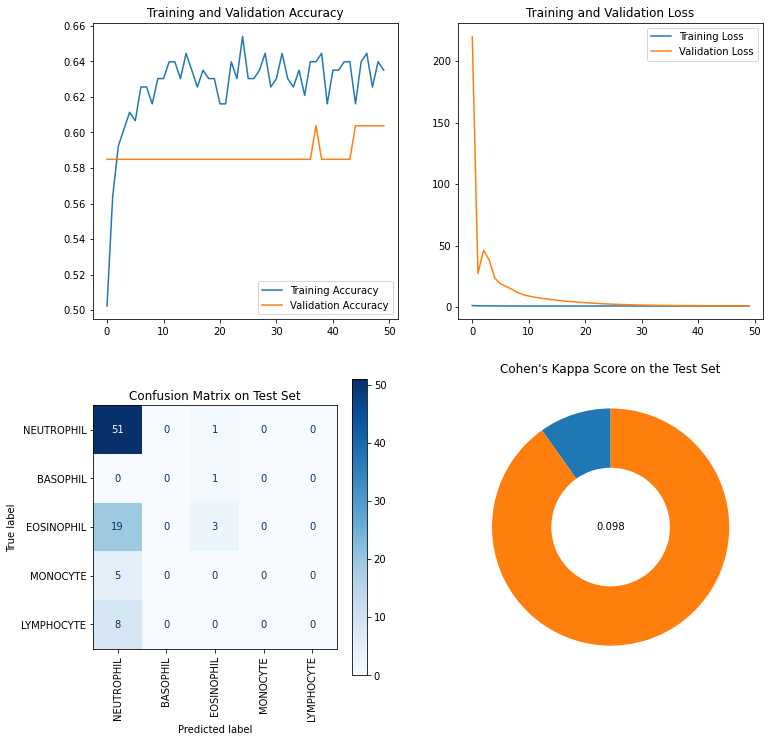

In [176]:
baseline_model.load_weights("models/baseline.hdf5")
evaluate_model(baseline_model, baseline_history, baseline_test)

__Takeaways:__ The model clearly suffers from the dataset being imbalanced. Almost every cell is labelled as a neutrophile.

__Next step:__ It might be useful to resample the data to balance the number of different leukocytes.

## Second model, balanced dataset

There are many methods of resampling data. In some areas, [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) has been gaining some popularity — a smart resampling method that generates new observations by sampling the feature space near existing observations. In our case, a simple oversampling of underrepresented classes should be enough.

In [135]:
def balance_dataset(dataset, ratio):
    data, targets = [np.array(a) for a in zip(*dataset)]
    class_count = [np.count_nonzero(targets == l) for l in range(len(CLASS_LABELS))]
    largest = np.max(class_count)

    indices = []
    for l, count in zip(range(len(CLASS_LABELS)), class_count):
        class_indices = np.where(targets == l)[0]
        indices += list(
            random.choices(class_indices, k=int(np.round(largest * ratio)))
            if count < largest * ratio
            else class_indices
        )

    return tf.data.Dataset.from_tensor_slices(
        (
            data[indices],
            targets[indices],
        )
    )

In [145]:
balanced_model = create_model(blocks=[1, 2])
balanced_train = balance_dataset(baseline_train, ratio=1)
compile_model(balanced_model, balanced_train)
balanced_history = fit_model(
    balanced_model,
    train_dataset=balanced_train,
    dev_dataset=baseline_dev,
    epochs=50,
    log_each=5,
    model_name="balanced",
    early_stop=None
)

2022-01-14 18:36:47.482400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:36:50.688001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 0, loss: 1.1829655170440674, accuracy: 0.47096773982048035
Epoch: 5, loss: 0.5047499537467957, accuracy: 0.8145161271095276
Epoch: 10, loss: 0.21104371547698975, accuracy: 0.9354838728904724
Epoch: 15, loss: 0.13012097775936127, accuracy: 0.9580644965171814
Epoch: 20, loss: 0.0909125804901123, accuracy: 0.9790322184562683
Epoch: 25, loss: 0.10142840445041656, accuracy: 0.9645161032676697
Epoch: 30, loss: 0.07114729285240173, accuracy: 0.9854838848114014
Epoch: 35, loss: 0.07381321489810944, accuracy: 0.9758064150810242
Epoch: 40, loss: 0.06584612280130386, accuracy: 0.9790322184562683
Epoch: 45, loss: 0.06845249235630035, accuracy: 0.9806451201438904


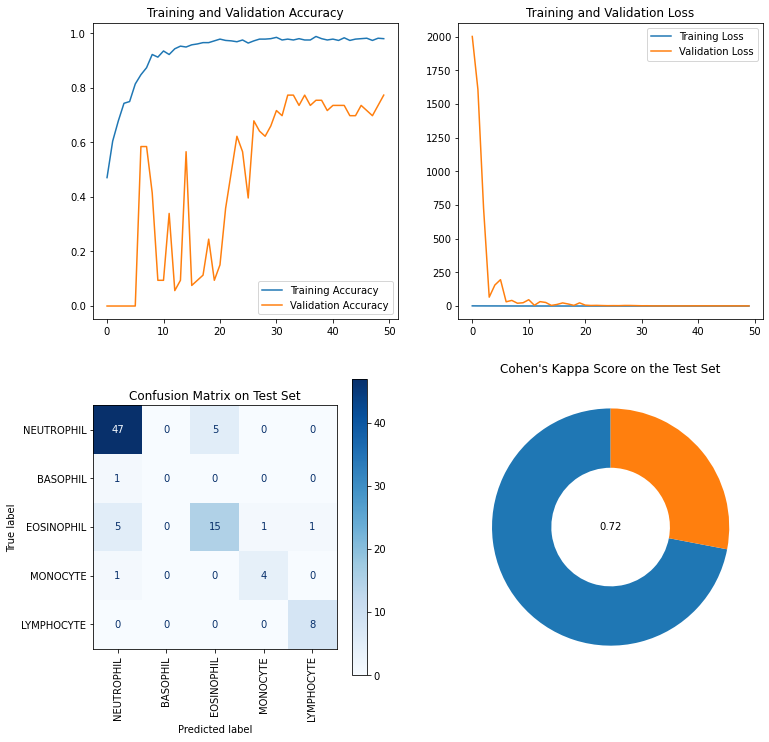

In [177]:
balanced_model.load_weights("models/balanced.hdf5")
evaluate_model(balanced_model, balanced_history, baseline_test)

__Takeaways:__ Training the _same_ model for the _same_ time on a more balanced dataset has yielded a __dramatic improvement__ in performance (over 730%).

__Next step:__ The model now has to find the cell in the image and then identify its type. Let's speed up the training (and mabye vene improve the performance) by isolating the cell in the image manually using open CV and feeding only the cells to the model.

## Leukocyte isolation by image segmentation with OpenCV

Because I don't have information about the positions of leukocytes in the training samples, I can't train a neural network to peform the image segmentation and isolate the leukocytes. Luckily, the white blood cells in the samples have certain characteristics that make it possible to detect them using only Open CV:

1. The background (i.e. area that is not an erytrocyte nor a leukocyte) is gray.
2. The colour of erytrocytes leans toward red hues.
3. The colour of leukocytes has a strong blue component.

I will construct simple masks to filter out (1) and (2) to be left only with the leukocytes. 

Firstly, a function to detect the background.

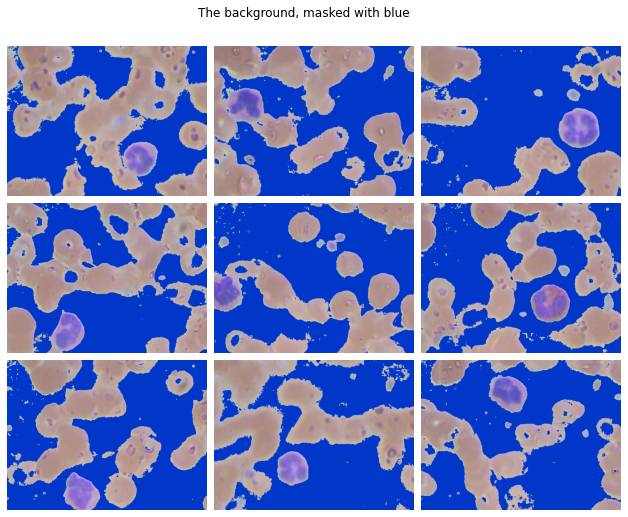

In [149]:
# Some custom colors for labelling
RED, GREEN, BLUE = (200, 55, 0), (0, 200, 55), (0, 55, 200)

def visualize_mask(img, mask, color=(255, 255, 255), no_bg=False):
    i = img.copy()
    i[mask(img)] = color
    if no_bg:
        i[~mask(img)] = (0, 0, 0)
    return i

def is_background(img):
    return (img[:, :, 0] > 180) & (img[:, :, 1] > 180) & (img[:, :, 2] > 180)


plot_grid(
    images=[visualize_mask(img, is_background, BLUE) for img in IMAGES],
    title="The background, masked with blue",
)

Then, a function to detect the erytrocytes. I'll use the fact that their colors have a really weak blue component, or a strong red component.

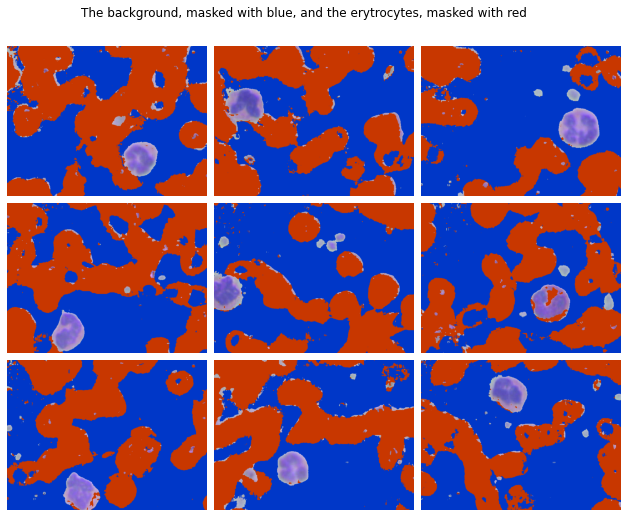

In [150]:
def is_erytrocyte(img):
    return (img[:, :, 2] < 150) | (img[:, :, 0] + 3 > img[:, :, 2])


plot_grid(
    images=[
        visualize_mask(visualize_mask(img, is_background, BLUE), is_erytrocyte, RED)
        for img in IMAGES
    ],
    title="The background, masked with blue, and the erytrocytes, masked with red",
)

The leukocyte masks (i.e. `not background & not erytrocyte`) themselves look like the following.

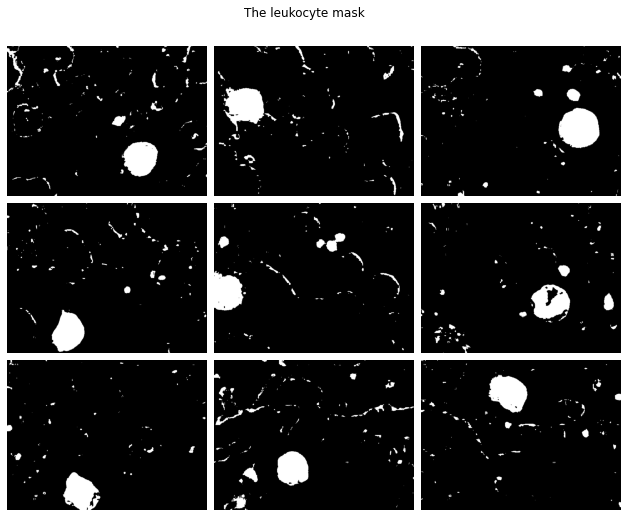

In [151]:
def is_leukocyte(img):
    return ~is_background(img) & ~is_erytrocyte(img)


plot_grid(
    images=[visualize_mask(img, is_leukocyte, no_bg=True) for img in IMAGES],
    title="The leukocyte mask",
)

To finalize the leukocyte masks I will:

1. Get rid of the little scraps and make the masks more round.
2. Find the bounding boxes of the leukocytes.
3. Finally, crop the leukocytes according to their bounding boxes.

I'll do (1) by _opening_ the image, that is erosion followed by dilation. 

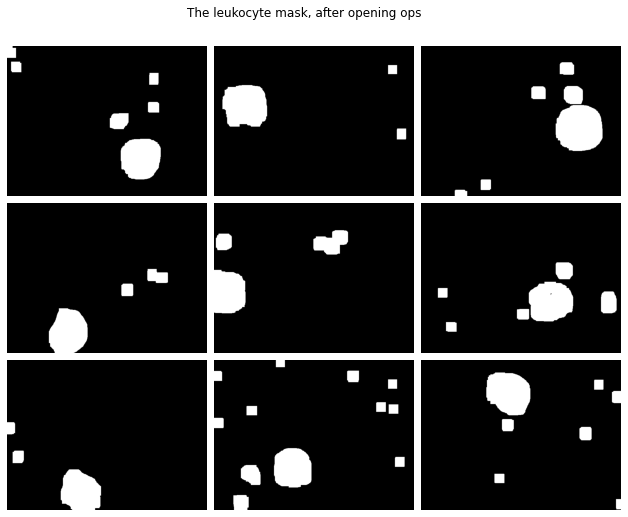

In [152]:
def leukocyte_mask(img):
    i = cv2.GaussianBlur(img, (21, 21), 2)
    i = visualize_mask(img, is_leukocyte, no_bg=True)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    i = cv2.erode(i, kernel, iterations=2)
    i = cv2.dilate(i, kernel, iterations=7)

    return np.max(i.astype(np.uint8), axis=2)


plot_grid(
    images=[leukocyte_mask(img) for img in IMAGES],
    title="The leukocyte mask, after opening ops",
    cmap="gray"
)

(2) It is now trivial to find the contours of the leukocytes, because they are currently the biggest unmasked area of the image.

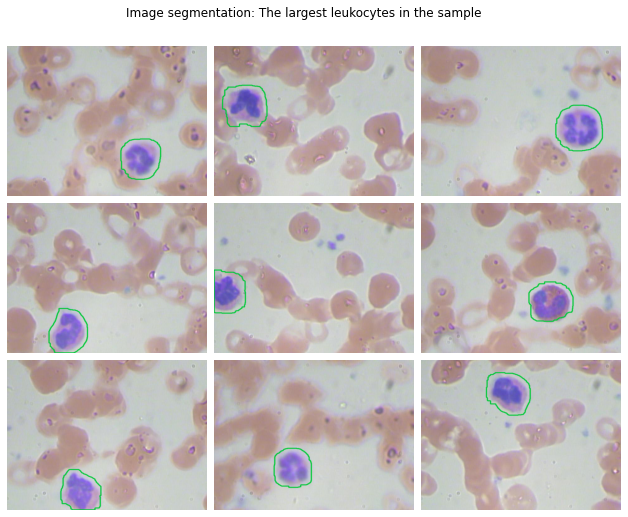

In [153]:
def area(c):
    rect = cv2.boundingRect(c)
    return rect[2] * rect[3]


def find_contours(img_thr):
    contours, _ = cv2.findContours(
        img_thr, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE
    )
    return sorted(contours, key=area, reverse=True)


def draw_contours(img, contours, which=-1, color=GREEN):
    im = img.copy()
    return cv2.drawContours(
        im, contours, contourIdx=which, color=color, thickness=2, lineType=cv2.LINE_AA
    )


CONTOURS = [find_contours(leukocyte_mask(img)) for img in IMAGES]

plot_grid(
    images=[draw_contours(img, cont, which=0) for img, cont in zip(IMAGES, CONTOURS)],
    title="Image segmentation: The largest leukocytes in the sample",
)


It is also easy to find their bounding boxes.

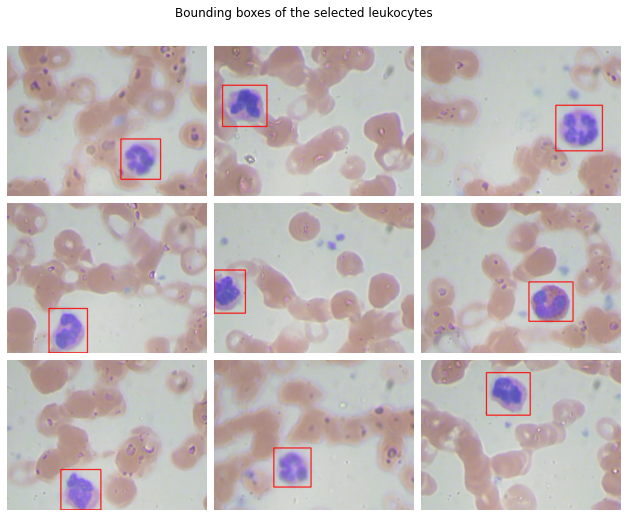

In [154]:
def box(contour):
    return np.int0(cv2.boxPoints(cv2.minAreaRect(contour)))


plot_grid(
    images=[
        draw_contours(img, [box(cs[0])], color=(255, 0, 0))
        for img, cs in zip(IMAGES, CONTOURS)
    ],
    title="Bounding boxes of the selected leukocytes",
)

I crop the images and seize each cell to a `128 x 128` square. A little bit of stretching doesn't hurt, on the contrary, it helps the model to generalize well.

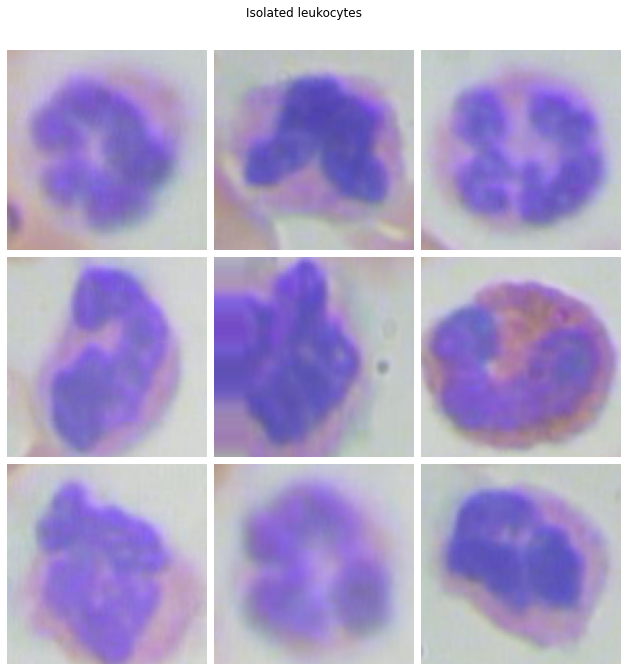

In [155]:
def crop(src, contour):
    # Get center, size, and angle from rect
    center, size, theta = cv2.minAreaRect(contour)
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D(center, 4 * theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, (src.shape[1] ,src.shape[0]))
    out = cv2.getRectSubPix(dst, size, center)
    return out

plot_grid(
    images=[
        cv2.resize(crop(img, cs[0]), (128, 128))
        for img, cs in zip(IMAGES, CONTOURS)
    ],
    title="Isolated leukocytes",
    top=0.95
)

I will add these images to the original datasets and use them from now on to train the models.

In [156]:
def isolate_cell(image, size=128):
    contours = find_contours(leukocyte_mask(image))
    padded = cv2.resize(crop(image, contours[0]), (size, size))
    return padded

data["cell"] = [isolate_cell(im) for im in data["image"]]

## Third model, balanced dataset with isolated cells

In [157]:
cell_train, cell_dev, cell_test = split_dataset(
    data=np.array([np.asarray(c) for c in data["cell"]]),
    targets=data["target"],
)
cell_train_balanced = balance_dataset(cell_train, ratio=1)

cell_model = create_model(blocks=[1, 2])
compile_model(cell_model, cell_train_balanced)
cell_history = fit_model(
    cell_model,
    train_dataset=cell_train_balanced,
    dev_dataset=cell_dev,
    epochs=50,
    log_each=5,
    model_name="cells",
    early_stop=None
)

2022-01-14 19:00:32.722194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 19:00:35.784591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 0, loss: 0.9970571994781494, accuracy: 0.5580645203590393
Epoch: 5, loss: 0.2090410441160202, accuracy: 0.9241935610771179
Epoch: 10, loss: 0.11644229292869568, accuracy: 0.949999988079071
Epoch: 15, loss: 0.08428223431110382, accuracy: 0.970967710018158
Epoch: 20, loss: 0.07162470370531082, accuracy: 0.97258061170578
Epoch: 25, loss: 0.048982784152030945, accuracy: 0.9870967864990234
Epoch: 30, loss: 0.05404544249176979, accuracy: 0.9790322184562683
Epoch: 35, loss: 0.04424373805522919, accuracy: 0.9887096881866455
Epoch: 40, loss: 0.04501914978027344, accuracy: 0.9903225898742676
Epoch: 45, loss: 0.05102803558111191, accuracy: 0.9838709235191345


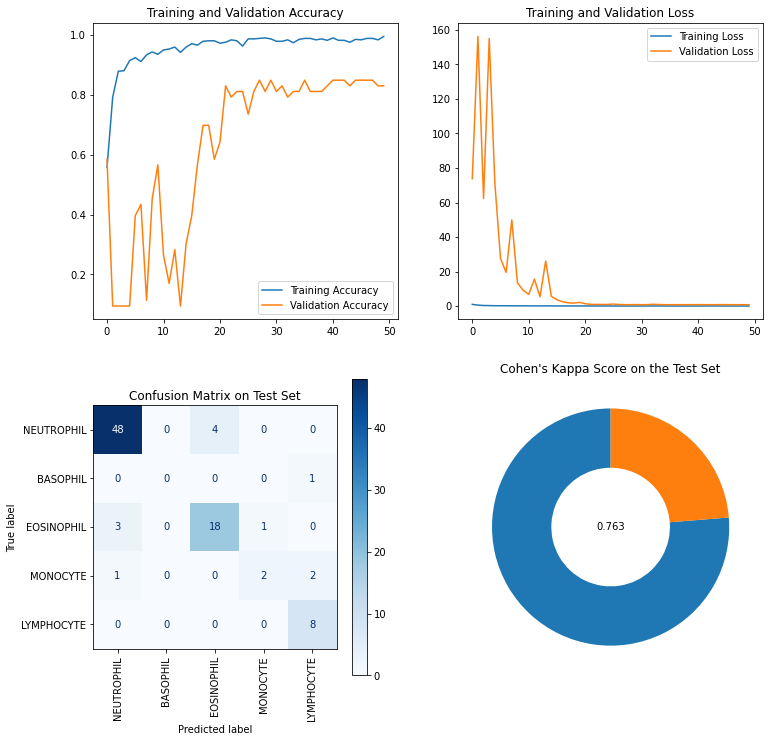

In [181]:
cell_model.load_weights("models/cells.hdf5")
evaluate_model(cell_model, cell_history, cell_test)

_Takeaways:_ Compared with the previous model (see the evaluation below), the model trained on isolated cells has a slightly better performance, converges slightly faster, and its training is much quicker thanks to the images being much smaller.

_Next, and the final, step:_ I'm quite happy with the model as it is; I will now add some layers to the model and lenghten the training process to get even better results. To make sure the model won't overfit, I will perform data augmentation.

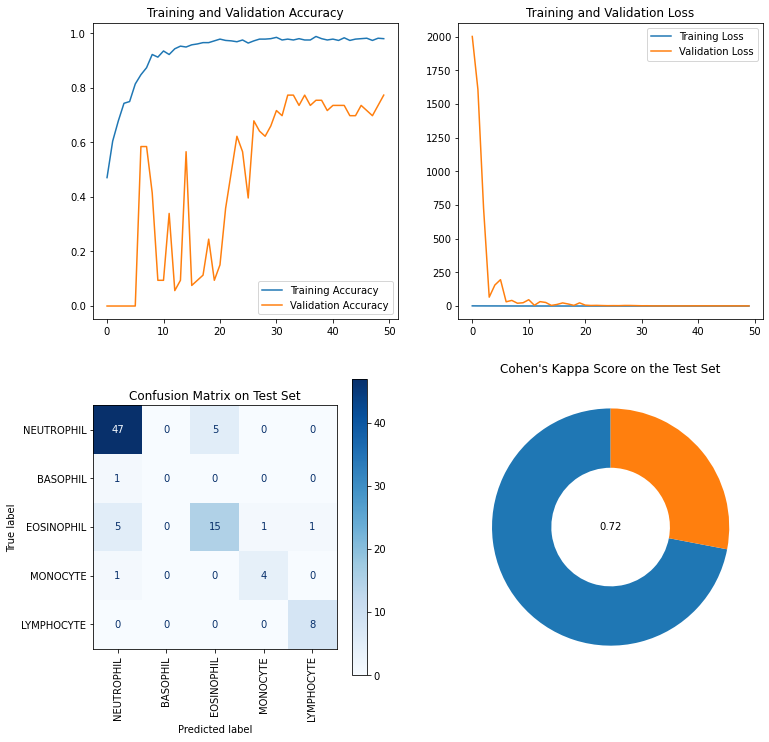

In [180]:
# Just as a reminder, the evaluation of the previous model
evaluate_model(balanced_model, balanced_history, baseline_test)

## Data augmentation

Increasing the model size without increasing the number of training samples would result in overfitting. That is why I will augment the dataset with additional observations that are made by modifying the existing ones.

In [184]:
CELLS = [np.asarray(c) for c in data["cell"][10:13]]

Flipping and rotation.

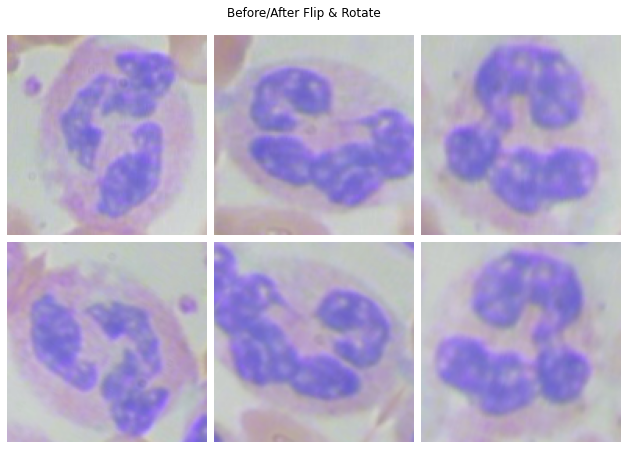

In [185]:
# def transform(img):
#     img = tf.image.random_flip_left_right(img)
#     img = tf.image.random_flip_up_down(img)
#     # with tf.device("/cpu:0"):
#     #     img = tf.keras.preprocessing.image.random_rotation(img, 360, row_axis=0, col_axis=1, channel_axis=2)
#     return img


def transform(img):
    with tf.device("/cpu:0"):
        return tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )(img)


plot_grid(
    images=CELLS + [transform(c) for c in CELLS],
    size=(2, 3),
    title="Before/After Flip & Rotate",
    top=1.25,
)

Shear transformation.

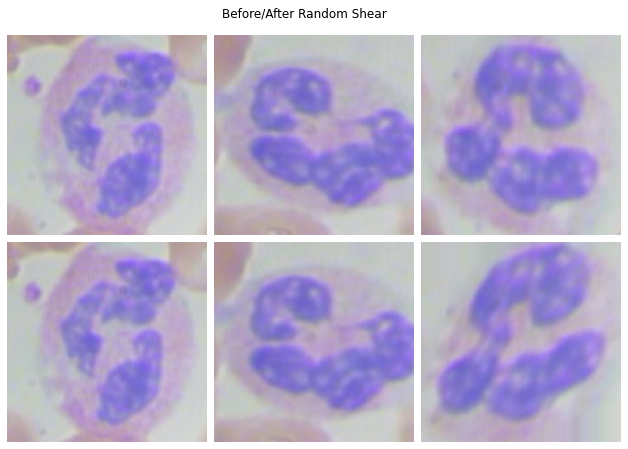

In [51]:
def shear(img):
    return tf.keras.preprocessing.image.random_shear(
        img,
        30,
        row_axis=0,
        col_axis=1,
        channel_axis=2,
        fill_mode="nearest",
    )


plot_grid(
    images=CELLS + [shear(c) for c in CELLS],
    size=(2, 3),
    title="Before/After Random Shear",
    top=1.25,
)

Brightness adjustments.

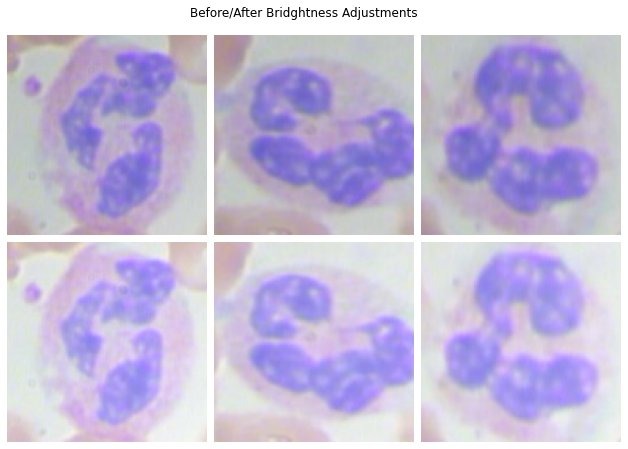

In [186]:
def brightness(img):
    return tf.image.random_brightness(img, max_delta=0.5, seed=SEED)

plot_grid(
    images=CELLS + [brightness(c) for c in CELLS],
    size=(2, 3),
    title="Before/After Bridghtness Adjustments",
    top=1.25,
)

Contrast adjustments.

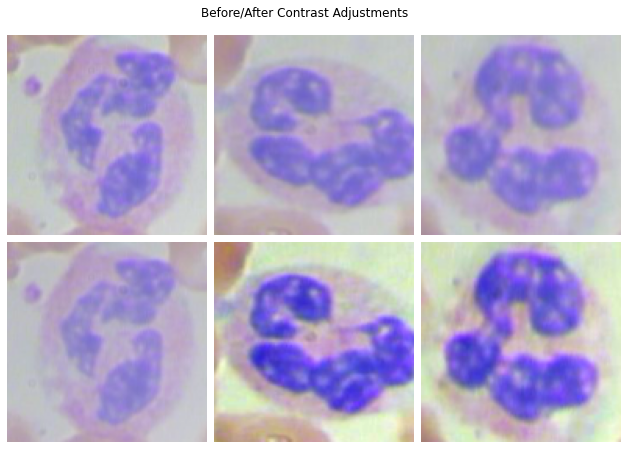

In [187]:
def contrast(img):
    return tf.image.random_contrast(img, lower=0.4, upper=2)

plot_grid(
    images=CELLS + [contrast(c) for c in CELLS],
    size=(2, 3),
    title="Before/After Contrast Adjustments",
    top=1.25,
)

And everything put together.

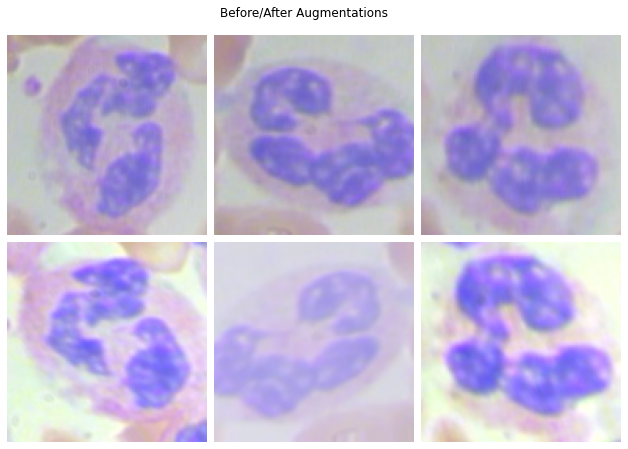

In [188]:
def augment(image, p=0.25):
    if random.random() < p:
        image = shear(image)
    if random.random() < p:
        image = brightness(image)
    if random.random() < p:
        image = contrast(image)
    if random.random() < p:
        image = transform(image)

    return image


plot_grid(
    images=CELLS + [augment(c, p=1) for c in CELLS],
    size=(2, 3),
    title="Before/After Augmentations",
    top=1.25,
)

## Final model, augmented and balanced dataset of isolated leukocytes

In [84]:
balanced_data, augmented_target = [
    np.array(x) for x in zip(*balance_dataset(cell_train, ratio=4))
]

In [85]:
augmented_data = np.array([augment(d, p=0.4) for d in balanced_data])

In [90]:
cell_data, cell_target = [np.array(x) for x in zip(*cell_train)]
augmented_data_2 = np.concatenate([cell_data, augmented_data])
augmented_target_2 = np.concatenate([cell_target, augmented_target])

In [195]:
augmented_model = create_model(blocks=[1, 2, 1, 2])
augmented_train = tf.data.Dataset.from_tensor_slices(
    (augmented_data_2, augmented_target_2)
)
compile_model(augmented_model, augmented_train)
augmented_history = fit_model(
    augmented_model,
    train_dataset=augmented_train,
    dev_dataset=cell_dev,
    epochs=200,
    log_each=5,
    model_name="augmented",
    early_stop=None
)

2022-01-14 20:06:03.543453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 20:06:09.402436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 0, loss: 0.9202863574028015, accuracy: 0.6518023610115051
Epoch: 5, loss: 0.24444925785064697, accuracy: 0.9078410267829895
Epoch: 10, loss: 0.14477308094501495, accuracy: 0.9528056979179382
Epoch: 15, loss: 0.1928652971982956, accuracy: 0.932367205619812
Epoch: 20, loss: 0.08559301495552063, accuracy: 0.963953971862793
Epoch: 25, loss: 0.07614845782518387, accuracy: 0.9713861346244812
Epoch: 30, loss: 0.03946712613105774, accuracy: 0.9869937300682068
Epoch: 35, loss: 0.09819921851158142, accuracy: 0.9702713489532471
Epoch: 40, loss: 0.02416565828025341, accuracy: 0.9959123730659485
Epoch: 45, loss: 0.024542564526200294, accuracy: 0.9914530515670776
Epoch: 50, loss: 0.017324035987257957, accuracy: 0.994425892829895
Epoch: 55, loss: 0.023548923432826996, accuracy: 0.9929394721984863
Epoch: 60, loss: 0.015263541601598263, accuracy: 0.9947975277900696
Epoch: 65, loss: 0.028051821514964104, accuracy: 0.9914530515670776
Epoch: 70, loss: 0.008142170496284962, accuracy: 0.9973987936973

2022-01-14 20:15:51.594779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


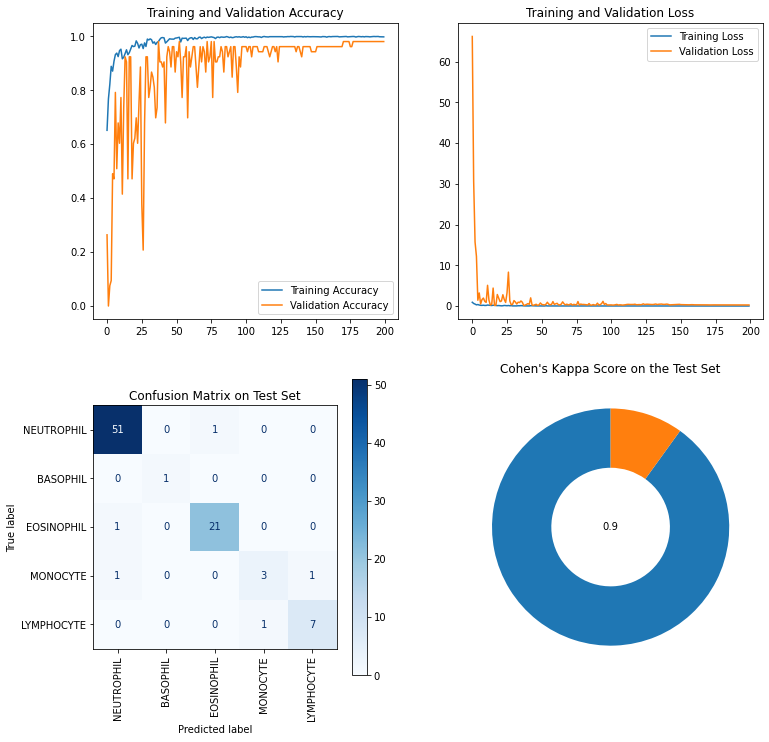

In [196]:
augmented_model.load_weights("models/augmented.hdf5")
evaluate_model(augmented_model, augmented_history, cell_test)

This model is almost ten times as good as the one I started with!

## Comparison with other models on Kaggle

Other people on Kaggle mostly use the other dataset supplied with this problem, that already contains augmented data. This means that the metrics between my and other models can't be directly compared.

On the other hand, we might gain _some_ insight from comparison with other models, regarding the number of parameters in the model and its performance.

In [197]:
augmented_model.summary()

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_366 (Conv2D)            (None, None, None,   2368        ['input_54[0][0]']               
                                16)                                                               
                                                                                                  
 max_pooling2d_53 (MaxPooling2D  (None, None, None,   0          ['conv2d_366[0][0]']             
 )                              16)                                                        

The model has 134,853 parameters.

In [202]:
augmented_model.evaluate(cell_test.batch(32))

3/3 [==============================] - 0s 41ms/step - loss: 0.3376 - sparse_categorical_accuracy: 0.9432


[0.3376390337944031, 0.9431818723678589]

As everyone seems to be using accuracy, I calculated it for my model as well to have a comparison point. Here is a comparison with three most upvoted models that are publicly available on Kaggle.

| Notebook                                                                                                                  | Accuracy on the test set | # of parameters |
|---------------------------------------------------------------------------------------------------------------------------|--------------------------|-----------------|
|this model| 94% | 134,853 |
| [Identify Blood Cell Subtypes From Images](https://www.kaggle.com/paultimothymooney/identify-blood-cell-subtypes-from-images) | 90%                      | not provided    |
| [Blood Cell Keras Inception](https://www.kaggle.com/kartiksharma522/blood-cell-keras-inception)                               | 86% (on validation set)  | 363,825         |
| [Deep Learning From Scratch + Insights](https://www.kaggle.com/placidpanda/deep-learning-from-scratch-insights)              | 83%                      | 16,732          |

## Conclusion

Main takeaways:
- residual connections are very effective and help bring the number of parameters down while maintaining the perfomance characteristics
- balancing the dataset improved generalization of the model
- isolating the cells with OpenCV improved the training speed tremendously, and even improved the model itself
- combining data augmentation with adding additional layers and epochs brought some nice small improvements as well

As is, the model isn't suitable for clinical use. However, it performs very well considering we only had less than 400 labeled examples.